#### **1. Apply CCA on Stiefel Manifold**

- Define the CCA objective function:
Formulate the objective function tr(U⊤C12VN)tr(U⊤C12​VN), where UU and VV are constrained to the Stiefel manifolds StC1(p,n)StC1​​(p,n) and StC2(p,m)StC2​​(p,m), respectively.

- Set up the Stiefel manifold constraints:
U⊤C1U=IpU⊤C1​U=Ip​ and V⊤C2V=IpV⊤C2​V=Ip​.

- Implement Riemannian optimization:
Polar-based or QR-based retractions to project points back onto the manifold after gradient descent steps.

Optimize the function:
- Gradient-based optimization techniques, invariance with respect to equivalence classes on the Grassmann manifold.

Validate the solution:
- Verify the canonical correlations and directions to ensure correctness.

#### **Loading datasets and preproc**

In [68]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(os.getcwd(), "..", "data", "bci_competition")
data_psd_path = os.path.join(data_path, "data_psd")

# Channel indices for left and right brain
left_channels = [0, 36, 60]  # C3, CP1, P3
right_channels = [24, 48, 84]  # C4, CP2, P4

def load_psd_file(file_path, include_labels=True):
    """
    Load a PSD file and extract features and labels     
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    features = data.iloc[:, :96]
    labels = data.iloc[:, 96] if include_labels else None
    return features, labels



In [69]:
def extract_left_right_features(features):
    """
    Extract left and right brain features from the PSD data.
    """
    left_features = pd.concat([features.iloc[:, i:i+12] for i in left_channels], axis=1) # skip each 12 columns
    right_features = pd.concat([features.iloc[:, i:i+12] for i in right_channels], axis=1)
    return left_features, right_features

In [136]:
train_files = [f for f in os.listdir(data_psd_path) if f.startswith("train")]
train_data = {}
for file in train_files:
    file_path = os.path.join(data_psd_path, file)
    features, labels = load_psd_file(file_path)
    left_features, right_features = extract_left_right_features(features)
    train_data[file] = (left_features, right_features, labels)

train_left = pd.concat([data[0] for data in train_data.values()])
train_right = pd.concat([data[1] for data in train_data.values()])
train_labels = pd.concat([data[2] for data in train_data.values()])



C:\Users\anaca\AppData\Local\Temp\ipykernel_27660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_27660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_27660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_27660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a fu

In [72]:
import numpy as np

def initialize_covariance_matrices(xt, yt, n_init_samples):
    """
    Initialize the covariance matrices using the first n_init_samples.
    """
    Cx = np.cov(xt[:n_init_samples], rowvar=False)
    Cy = np.cov(yt[:n_init_samples], rowvar=False)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:xt.shape[1], xt.shape[1]:]
    return Cx, Cy, Cxy

In [73]:
def resample_features(features, step=8):
    """ 
    Resample features by averaging over intervals of 0.5s.
    """
    num_samples = len(features)
    num_intervals = num_samples // step
    resampled = np.mean(features[:num_intervals * step].values.reshape(-1, step, features.shape[1]), axis=1)
    return pd.DataFrame(resampled)

train_left_resampled = resample_features(train_left)
train_right_resampled = resample_features(train_right)

xt = train_left_resampled  # Left electrode features
yt = train_right_resampled  # Right electrode features

# Check there are no NaN values
assert np.isnan(xt).sum().sum() == 0
assert np.isnan(yt).sum().sum() == 0


In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

xt = np.load("xt.npy")  # left hemisphere features (n_samples, 36)
yt = np.load("yt.npy")  # right hemisphere features (n_samples, 36)

# Preprocess (normalize)
xt = (xt - np.mean(xt, axis=0)) / np.std(xt, axis=0)
yt = (yt - np.mean(yt, axis=0)) / np.std(yt, axis=0)

n_samples, nx = xt.shape
_, ny = yt.shape
p = 4  # Rank of decomposition (number of principal directions)
beta = 0.98  # Forgetting factor, test with 0.99, 0.98, 0.95


The norm of zx is extremely large (~10141014), which strongly suggests numerical instability rather than small values or singular matrices due to correlation. Given that the issue appears at different iterations each time, it’s likely that the covariance updates (which include exponential forgetting via β) are amplifying certain values to unstable magnitudes.

Exploding gradient issue.

In [75]:
# Determining step lengths
def objective(U, V, Cxy):
    return np.trace(U.T @ Cxy @ V)

def line_search(U, V, Cxy, grad_U, grad_V, step_size=1.0, alpha=0.5, beta=0.9) -> float:
    """
    Perform backtracking line search to find the best step size.
    
    Parameters:
        U, V      - Current matrices
        Cxy       - Cross-covariance matrix
        grad_U, grad_V - Gradients for U and V
        step_size - Initial step size (default 1.0)
        alpha     - Reduction factor (default 0.5)
        beta      - Acceptance parameter (default 0.9)
    
    Returns:
        optimal step size
    """
    current_obj = objective(U, V, Cxy)
    
    while step_size > 1e-6:  # Prevent step size from becoming too small
        U_new = U + step_size * grad_U
        V_new = V + step_size * grad_V
        new_obj = objective(U_new, V_new, Cxy)
        
        if new_obj >= beta * current_obj:  # If objective improves, accept step size
            return step_size
        
        step_size *= alpha  # Reduce step size
    
    return step_size  # Return smallest step size if no improvement


In [93]:
from scipy.linalg import qr

def compute_compressed_covariance(zx: np.ndarray, zy: np.ndarray, beta: float, t: int) -> tuple:
    """
    Compute the compressed covariance matrices of a compressed sample.
    """
    epsilon = 1e-4  # Regularization parameter
    # Compute the compressed auto-covariance matrices
    G_x = beta * np.eye(p) + zx @ zx.T
    G_y = beta * np.eye(p) + zy @ zy.T
    print(f"Sample {t}: Condition number of G_x = {np.linalg.cond(G_x)}")
    print(f"Sample {t}: Condition number of G_y = {np.linalg.cond(G_y)}")

    if np.linalg.cond(G_x) > 1e12:
        print(f"Sample {t}: G_x is ill-conditioned, adding regularization")
        G_x += epsilon * np.eye(p)
    if np.linalg.cond(G_y) > 1e12:
        print(f"Sample {t}: G_y is ill-conditioned, adding regularization")
        G_y += epsilon * np.eye(p)
    # Check if G_x and G_y are invertible
    if np.linalg.matrix_rank(G_x) < p:
        print("G_x is not invertible")
        print(f"DEBUGGING: Sample {t} | zx norm: {np.linalg.norm(zx)}")
    if np.linalg.matrix_rank(G_y) < p:
        print("G_y is not invertible")
        print(f"DEBUGGING: Sample {t} | zy norm: {np.linalg.norm(zy)}")

    return G_x, G_y

def compute_compressed_samples(U_tprima: np.ndarray, V_tprima: np.ndarray, x_t: np.ndarray, y_t: np.ndarray, beta: float, t: int) -> tuple:
    """
    Compute the compressed samples of a given sample.
    """
    # Compute compressed samples
    zx = U_tprima.T @ x_t
    zy = V_tprima.T @ y_t
    max_norm = 1e3 
    if np.linalg.norm(zx) > max_norm:
        print(f"Clipping zx at sample {t} | Original norm: {np.linalg.norm(zx)}")
        zx = zx / np.linalg.norm(zx) * max_norm
        zy /= np.linalg.norm(zy) + 1e-6  # Prevent division by zero

    return zx, zy

def compute_initial_matrices(zx: np.ndarray, zy: np.ndarray, beta: float) -> tuple:
    """ 
    Compute the initial matrices Ou and Ov.    
    """
    alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
    px = 1 - np.sqrt(1 / (1 + alpha_x))
    Ou = beta**(-0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))
    # print("DEBUGGING: shapes of alpha_x, px, Ou", alpha_x.shape, px.shape, Ou.shape)

    alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
    py = 1 - np.sqrt(1 / (1 + alpha_y))
    Ov = beta**(-0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))
    # print("DEBUGGING: shapes of alpha_y, py, Ov", alpha_y.shape, py.shape, Ov.shape)

    return Ou, Ov, px, py

def initialize_subspaces(nx: int, ny: int, p: int) -> tuple:
    """
    Initialize the subspaces U and V.
    """
    U_t = np.random.randn(nx, p)
    V_t = np.random.randn(ny, p)
    U_t, _ = np.linalg.qr(U_t)  # Orthonormalize
    V_t, _ = np.linalg.qr(V_t)
    U_tprima = U_t
    V_tprima = V_t
    U_tnew = U_t
    V_tnew = V_t
    U_tprev = U_t
    V_tprev = V_t

    return U_t, V_t, U_tprima, V_tprima, U_tnew, V_tnew, U_tprev, V_tprev

def update_UV_using_qr_retraction(U: np.ndarray, V: np.ndarray, grad_U: np.ndarray, grad_V: np.ndarray, optimal_step: float) -> tuple:
    """
    Update the U matrix using the polar retraction.
    """
    U_new, _ = np.linalg.qr(U + optimal_step * grad_U)  
    V_new, _ = np.linalg.qr(V + optimal_step * grad_V)

    return U_new, V_new

def update_UV_with_residuals(U: np.ndarray, V: np.ndarray, Cx: np.ndarray, Cy: np.ndarray, fx, fy, N: np.ndarray, zx: np.ndarray, zy: np.ndarray, step_size: float, px, py) -> tuple:
    """
    Update the U and V matrices using the residuals.
    """
    bar_zx = zx - (zx.T @ N @ zy) / (zy.T @ N @ N @ zy) * zy
    bar_alpha_x = (fx.T @ Cx @ fx + bar_zx.T @ bar_zx) / (4 * (zy.T @ N @ N @ zy) * step_size**2)
    bar_px = 1 - np.sqrt(1 / (1 + bar_alpha_x))
    bar_zy = zy - (zy.T @ N @ zx) / (zx.T @ N @ N @ zx) * zx
    bar_alpha_y = (fy.T @ Cy @ fy + bar_zy.T @ bar_zy) / (4 * (zx.T @ N @ N @ zx) * step_size**2)
    bar_py = 1 - np.sqrt(1 / (1 + bar_alpha_y))

    # Polar retraction update
    U += step_size * ((1 - px) * fx @ zy.T @ N + 0.5 * (1 - px) * U @ bar_zx @ zy.T @ N
                        - 0.5 * (1 - bar_px) * U @ N @ zy @ bar_zx.T)
    V += step_size * ((1 - py) * fy @ zx.T @ N + 0.5 * (1 - py) * V @ bar_zy @ zx.T @ N
                        - 0.5 * (1 - bar_py) * V @ N @ zx @ bar_zy.T)

    return U, V

def second_gradient_with_residuals(U_tprima: np.ndarray, V_tprima: np.ndarray, zx: np.ndarray, zy: np.ndarray, fx: np.ndarray, fy: np.ndarray, N: np.ndarray) -> tuple:

    grad_U = fx @ zy.T @ N + 0.5 * U_tprima @ (zx @ zy.T @ N - N @ zy @ zx.T)
    grad_V = fy @ zx.T @ N + 0.5 * V_tprima @ (zy @ zx.T @ N - N @ zx @ zy.T)

    return grad_U, grad_V

In [130]:
def adaptive_cca_one_step(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-4  # make matrix invertible

    # Initialize covariance matrices
    Cx, Cy, Cxy = initialize_covariance_matrices(xt, yt, n_init_samples)

    # Initialize U and V as random orthonormal matrices
    U_t, V_t, _, _, U_tnew, V_tnew, _, _ = initialize_subspaces(nx, ny, p)

    reconstruction_errors = []
    detected_changes = []
        
    for t in range(100, n_samples):
        print(f"------SAMPLE------ {t}/{n_samples}")
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Compute compressed samples
        zx, zy = compute_compressed_samples(U_t, V_t, x_t, y_t, beta, t)
        
        # Compute compressed covariance matrices
        G_x_t, G_y_t = compute_compressed_covariance(zx, zy, beta, t)

        # Compute initial matrices Ou, Ov
        Ou, Ov, px, py = compute_initial_matrices(zx, zy, beta)

        # ------- Gradient Ascent Step -------
        L_t = U_t.T @ Cxy @ V_t
        N = np.linalg.inv(np.eye(L_t.shape[0]) + L_t @ L_t.T)

        grad_Ou = np.linalg.inv(G_x_t + epsilon * np.eye(p)) @ L_t @ Ov @ N - 0.5 * Ou @ L_t @ N - 0.5 * Ou @ N @ L_t.T
        grad_Ov = np.linalg.inv(G_y_t + epsilon * np.eye(p)) @ L_t.T @ Ou @ N - 0.5 * Ov @ L_t.T @ N - 0.5 * Ov @ N @ L_t
        grad_projected_U = U_t @ grad_Ou
        grad_projected_V = V_t @ grad_Ov
        # Update U and V using QR retraction
        U_tnew, V_tnew = update_UV_using_qr_retraction(U_t, V_t, grad_projected_U, grad_projected_V, step_size)

        # Update covariance matrices adaptively
        Cx = beta * Cx + x_t @ x_t.T
        Cy = beta * Cy + y_t @ y_t.T

        # Compute compressed samples with the metric update matrices
        zx, zy = compute_compressed_samples(U_tnew, V_tnew, x_t, y_t, beta, t)

        # Compute residuals
        fx = np.linalg.inv(Cx) @ x_t - U_tnew @ zx
        fy = np.linalg.inv(Cy) @ y_t - V_tnew @ zy
        print(f"DEBUGGING: Sample {t} | Residual f_x: {fx.T @ fx}, Residual f_y: {fy.T @ fy}")

        # Compute reconstruction error
        rx_t = np.linalg.inv(Cx) @ U_t @ U_t.T @ x_t
        ry_t = np.linalg.inv(Cy) @ V_t @ V_t.T @ y_t
        c_t = 0.5 * (rx_t.T @ Cx @ rx_t / nx + ry_t.T @ Cy @ ry_t / ny)
        print(f"Reconstruction error at sample {t}: {c_t.item()}")
        reconstruction_errors.append(c_t.item())

        if t > 100:
            threshold = np.percentile(reconstruction_errors[:t], 90)
            if reconstruction_errors[-1] > threshold:
                print(f"Sample {t} | Detected change in distribution")
                # if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                detected_changes.append(t)

        # Update U and V for next iteration
        U_t = U_tnew
        V_t = V_tnew

    return reconstruction_errors, detected_changes

In [132]:
def adaptive_cca(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-4 # make matrix invertible

    # Initialize covariance matrices
    Cx, Cy, Cxy = initialize_covariance_matrices(xt, yt, 100)
    Cx_prev = Cx
    Cy_prev = Cy

    # Initialize U and V as random orthonormal matrices
    U_t, V_t, U_tprima, V_tprima, U_tnew, V_tnew, U_tprev, V_tprev = initialize_subspaces(nx, ny, p)

    reconstruction_errors = []
    detected_changes = []
        
    # iterate starting on 100th
    for t in range(100, n_samples):
        print(f"------SAMPLE------ {t}/{n_samples}")
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Compute compressed samples
        zx, zy = compute_compressed_samples(U_tprima, V_tprima, x_t, y_t, beta, t)
        # Compute compressed covariance matrices
        G_x_t, G_y_t = compute_compressed_covariance(zx, zy, beta, t)
        # Compute initial matrices Ou, Ov
        Ou, Ov, px, py = compute_initial_matrices(zx, zy, beta)

        # ------- First Gradient Ascent Step -------
        U_tprima = U_tprev @ Ou
        V_tprima = V_tprev @ Ov
        L_t = U_t.T @ Cxy @ V_t
        N = np.linalg.inv(np.eye(L_t.shape[0]) + L_t @ L_t.T)

        grad_Ou = np.linalg.inv(G_x_t + epsilon * np.eye(p)) @ L_t @ Ov @ N - 0.5 * Ou @ L_t @ N - 0.5 * Ou @ N @ L_t.T
        grad_Ov = np.linalg.inv(G_y_t + epsilon * np.eye(p)) @ L_t.T @ Ou @ N - 0.5 * Ov @ L_t.T @ N - 0.5 * Ov @ N @ L_t
        grad_projected_U = U_tprima @ grad_Ou
        grad_projected_V = V_tprima @ grad_Ov
        optimal_step = line_search(U_tprima, V_tprima, Cxy, grad_projected_U, grad_projected_V, step_size=1.0, alpha=0.5, beta=0.9)
        print(f"Optimal step size: {optimal_step}")
        # Update U and V
        U_tnew, V_tnew = update_UV_using_qr_retraction(U_tprima, V_tprima, grad_projected_U, grad_projected_V, optimal_step)

        # Update covariance matrices adaptively
        Cx = beta * Cx + x_t @ x_t.T
        Cy = beta * Cy + y_t @ y_t.T

        # Compute compressed samples with the metric update matrices
        zx, zy = compute_compressed_samples(U_tprima, V_tprima, x_t, y_t, beta, t)
        # Compute residuals
        fx = np.linalg.inv(Cx) @ x_t - U_tprima @ zx
        fy = np.linalg.inv(Cy) @ y_t - V_tprima @ zy
        print(f"DEBUGGING: Sample {t} | Residual f_x: {fx.T @ fx}, Residual f_y: {fy.T @ fy}")

        # ------ Second Gradient Ascent Step -------
        grad_U, grad_V = second_gradient_with_residuals(U_tnew, V_tnew, zx, zy, fx, fy, N)  
        # U_tnew, V_tnew = update_UV_with_residuals(U_tnew, V_tnew, Cx, Cy, fx, fy, N, zx, zy, optimal_step, px, py)
        U_tnew, V_tnew = update_UV_using_qr_retraction(U_tnew, V_tnew, grad_U, grad_V, optimal_step)
        Cxy = beta * Cxy + x_t @ y_t.T

        # Compute reconstruction error
        rx_t = (np.linalg.inv(Cx_prev) @ U_tprev @ U_tprev.T) @ x_t
        ry_t = (np.linalg.inv(Cy_prev) @ V_tprev @ V_tprev.T) @ y_t
        c_t = 0.5 * (rx_t.T @ Cx_prev @ rx_t / nx + ry_t.T @ Cy_prev @ ry_t / ny)
        print(f"Reconstruction error at sample {t}: {c_t.item()}")
        reconstruction_errors.append(c_t.item())

        # Detect changes based on a threshold
        if t > 100:
            threshold = np.percentile(reconstruction_errors[:t], 90)
            if reconstruction_errors[-1] > threshold:
                print(f"Sample {t} | Detected change in distribution")
                # if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                detected_changes.append(t)
                    
        U_t = U_tnew
        V_t = V_tnew
        U_tprev = U_tprima  # Save the previous step for next iteration
        V_tprev = V_tprima
        Cx_prev = Cx
        Cy_prev = Cy

    return reconstruction_errors, detected_changes



In [105]:
def plot_reconstruction_errors(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True):
    """
    Plot reconstruction errors with detected and true change points.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(reconstruction_errors))

    # Plot reconstruction errors
    plt.plot(x, reconstruction_errors, label="Reconstruction Error", color='blue')

    # Plot detected changes
    if with_changes:
        for change in detected_changes:
            plt.axvline(change, color='orange', linestyle='--', label="Detected Change" if change == detected_changes[0] else "")

    # Plot ground truth change points
    for truth in range(0, len(reconstruction_errors), ground_truth_interval):
        plt.axvline(truth, color='red', linestyle='dashed', label="Ground Truth" if truth == 0 else "")

    # Add threshold line
    threshold = np.percentile(reconstruction_errors, 90)
    plt.axhline(threshold, color='black', linestyle='dotted', label="Threshold")

    plt.xlabel("Time (ms)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error and Detected Changes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [135]:
reconstruction_errors, detected_changes = adaptive_cca(xt, yt, beta=0.995, p=4, step_size=0.01, n_init_samples=100)

------SAMPLE------ 100/3902
Sample 100: Condition number of G_x = 3.6034638536332126
Sample 100: Condition number of G_y = 1.5897998928938775
Optimal step size: 1.0
DEBUGGING: Sample 100 | Residual f_x: [[0.95678186]], Residual f_y: [[0.50353249]]
Reconstruction error at sample 100: 0.4279529424664785
------SAMPLE------ 101/3902
Sample 101: Condition number of G_x = 3.5977848369780916
Sample 101: Condition number of G_y = 2.0085059042737825
Optimal step size: 1.0
DEBUGGING: Sample 101 | Residual f_x: [[1.10461185]], Residual f_y: [[0.68800617]]
Reconstruction error at sample 101: 0.39139226313801284
------SAMPLE------ 102/3902
Sample 102: Condition number of G_x = 8.35780857924507
Sample 102: Condition number of G_y = 1.8001709627629952
Optimal step size: 1.0
DEBUGGING: Sample 102 | Residual f_x: [[1.70307687]], Residual f_y: [[0.56303682]]
Reconstruction error at sample 102: 0.6723206571090192
Sample 102 | Detected change in distribution
------SAMPLE------ 103/3902
Sample 103: Conditi

KeyboardInterrupt: 

------SAMPLE------ 100/3902
Sample 100: Condition number of G_x = 6.655075246074416
Sample 100: Condition number of G_y = 2.1899372038489995
Optimal step size: 1.0
DEBUGGING: Sample 100 | Residual f_x: [[1.53737146]], Residual f_y: [[0.67992421]]
Reconstruction error at sample 100: 1.074823130194956
------SAMPLE------ 101/3902
Sample 101: Condition number of G_x = 1.9805994284265493
Sample 101: Condition number of G_y = 1.8574028851448743
Optimal step size: 1.0
DEBUGGING: Sample 101 | Residual f_x: [[0.92208167]], Residual f_y: [[0.66253141]]
Reconstruction error at sample 101: 0.19040368908128869
------SAMPLE------ 102/3902
Sample 102: Condition number of G_x = 7.813046119272286
Sample 102: Condition number of G_y = 1.3732690657477014
Optimal step size: 0.0625
DEBUGGING: Sample 102 | Residual f_x: [[2.05160758]], Residual f_y: [[0.79183778]]
Reconstruction error at sample 102: 1.4493035343717602
Sample 102 | Detected change in distribution
------SAMPLE------ 103/3902
Sample 103: Condi

KeyboardInterrupt: 

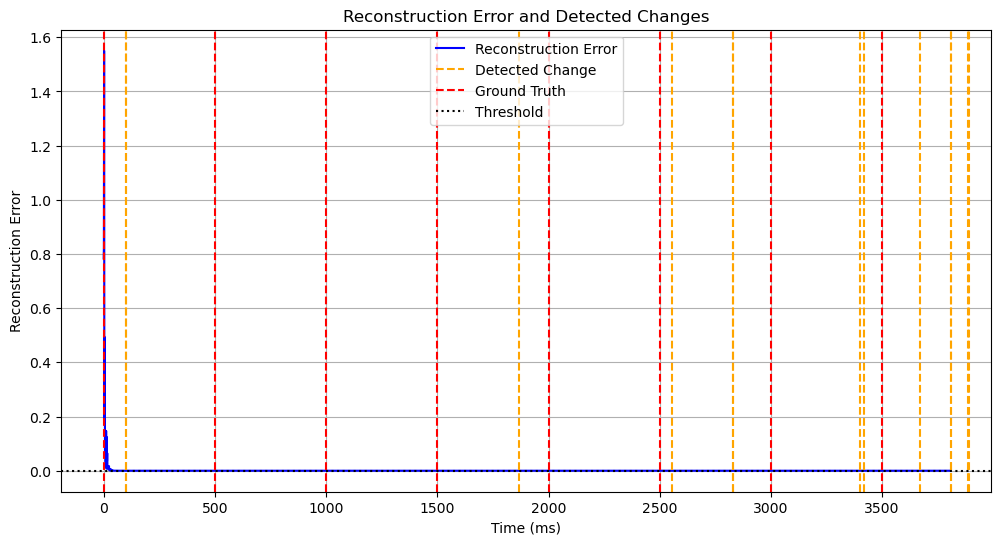

In [117]:
plot_reconstruction_errors(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True)